In [1]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import os
from PIL import Image

import cv2
import matplotlib.pyplot as plt

import random

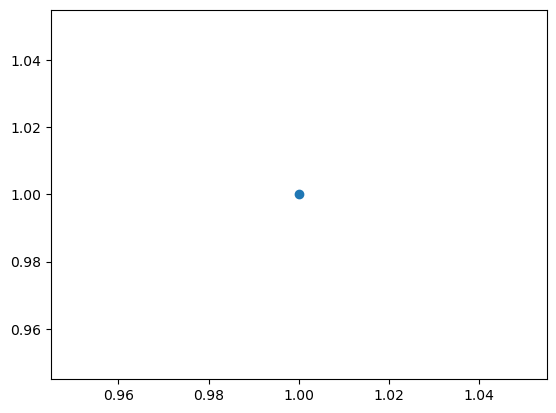

In [2]:
plt.scatter(1,1)


In [3]:
train_data_path = r'data_road/training/image_2'
train_gt_path = r'data_road/training/image_2'

In [4]:
class RoadSegmentationDataset(Dataset):
    def __init__(self, image_dir, image_transform=None , label_transform=None , augment=False):
        self.image_dir = image_dir
        # self.label_dir = label_dir
        self.augment = augment
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.image_names = os.listdir(image_dir)
        # self.masks_names = os.listdir(label_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        # mask_name = self.masks_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        # label_path = os.path.join(self.label_dir, mask_name)

        

        # Generate the corresponding mask path based on the naming convention
        mask_path = image_path.replace("image_2", "gt_image_2")
        mask_path = mask_path.replace("um_", "um_road_")
        mask_path = mask_path.replace("umm_", "umm_road_")
        mask_path = mask_path.replace("uu_", "uu_road_")

        # label = Image.open(label_path).convert("L")  # assuming labels are in grayscale

        # Read the image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        mask = np.array(mask)

        road_label = np.array([255, 0, 255])
        
        # Create a binary mask where road areas are 1 and non-road areas are 0
        binary_mask = np.all(mask == road_label, axis=-1).astype(np.uint8)
        binary_mask = np.expand_dims(binary_mask, axis=-1)  # Add channel dimension

        binary_mask = Image.fromarray(binary_mask.squeeze() * 255)  # Scale up to 255 for visualization

        if self.augment:
            image, binary_mask = self.apply_augmentations(image, binary_mask)

        # Apply transformations if provided
        if self.image_transform:
            image = self.image_transform(image)
        
        if self.label_transform:
            binary_mask = self.label_transform(binary_mask)
        else:
            # Convert mask to tensor without additional transformations
            binary_mask = transforms.ToTensor()(binary_mask)

        return {'image': image, 'segmentation_mask': binary_mask}
    
    def apply_augmentations(self, image, mask):
        # Example augmentation: random horizontal flip
        if random.random() > 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)
        
        # Additional augmentations can be added here
        return image, mask


In [5]:
# Define the transformations for the images
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

# Define the transformations for the labels (only resizing and converting to tensor)
label_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize labels to a fixed size
    transforms.ToTensor(),  # Convert labels to PyTorch tensors
])

In [6]:
dataset = RoadSegmentationDataset(image_dir=train_data_path , image_transform=image_transform , label_transform=label_transform , augment=True)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

In [7]:
# Define sizes for training, validation, and testing
TRAINSET_SIZE = int(0.7 * len(dataset))
VALIDSET_SIZE = int(0.2 * len(dataset))
TESTSET_SIZE = len(dataset) - TRAINSET_SIZE - VALIDSET_SIZE

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [TRAINSET_SIZE, VALIDSET_SIZE, TESTSET_SIZE])

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

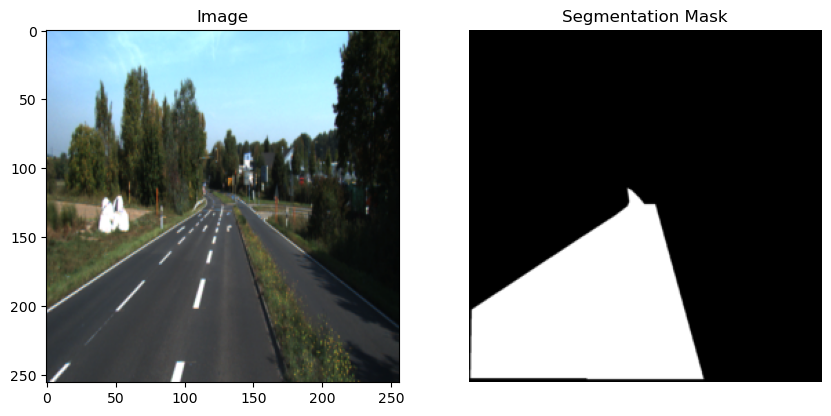

In [8]:
def show_image_and_label(dataset, idx):
    data = dataset[idx]
    image, mask = data['image'], data['segmentation_mask']
    inv_normalize = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    image = inv_normalize(image)
    image = image.permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8) 
    mask = mask.squeeze().numpy()

    plt.figure(figsize=(10, 5))
        
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Segmentation Mask')
    plt.axis('off')

    plt.show()

show_image_and_label(dataset, 14)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


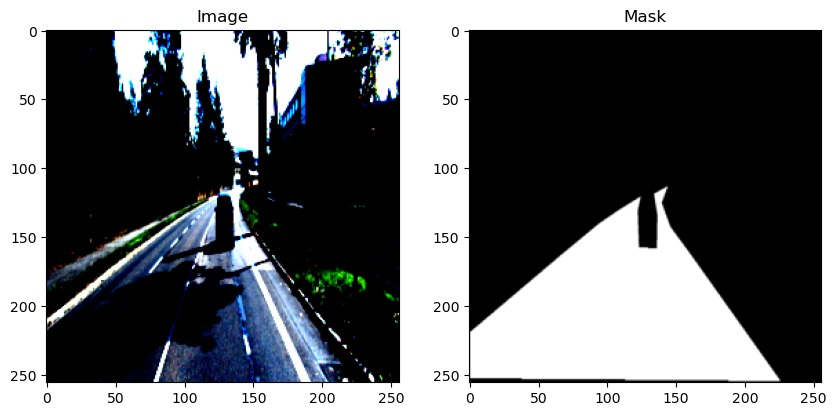

In [9]:
def visualize_sample(dataset, index):
    sample = dataset[index]
    image = sample['image'].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C) for visualization
    mask = sample['segmentation_mask'][0].numpy()  # Convert from (1, H, W) to (H, W) for visualization
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')
    plt.show()

# Example usage
visualize_sample(dataset, 32)

## Define Network

In [10]:
vgg16_model = models.vgg16(pretrained=True)


c:\Users\ishaa\anaconda3\envs\road_segmentation\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ishaa\anaconda3\envs\road_segmentation\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
class VGGFCN8(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(VGGFCN8, self).__init__()
        
        # Load the pretrained VGG16 model
        vgg16 = models.vgg16(pretrained=pretrained)
        
        # Extract the features part of VGG16
        self.features = vgg16.features
        
        # We will use these specific layers for the encoder
        self.enc1 = nn.Sequential(*list(self.features.children())[:17])  # Block 1 to 3
        self.enc2 = nn.Sequential(*list(self.features.children())[17:24]) # Block 4
        self.enc3 = nn.Sequential(*list(self.features.children())[24:])   # Block 5
        
        # Decoder part with upsampling layers
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1)
        )
        
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(512 + 512, 256, kernel_size=3, padding=1)
        )
        
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True),
            nn.Conv2d(256 + 256, num_classes, kernel_size=3, padding=1)
        )
        
        # Initialize weights for the newly added layers
        self._initialize_weights()

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)  # block3_pool
        c2 = self.enc2(c1) # block4_pool
        c3 = self.enc3(c2) # block5_pool
        
        # Decoder
        u1 = self.up1(c3)
        d1 = torch.cat((u1, c2), dim=1)  # Concatenate with block4_pool features
        
        u2 = self.up2(d1)
        d2 = torch.cat((u2, c1), dim=1)  # Concatenate with block3_pool features
        
        u3 = self.up3(d2)
        
        return u3
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

# Parameters
IMG_SIZE = 256
N_CLASSES = 1  # Adjust as needed for your specific task (e.g., 2 for binary segmentation)

# Create the model
model = VGGFCN8(num_classes=N_CLASSES, pretrained=True)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


VGGFCN8(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [12]:
data = dataset[5]
image, mask = data['image'], data['segmentation_mask']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


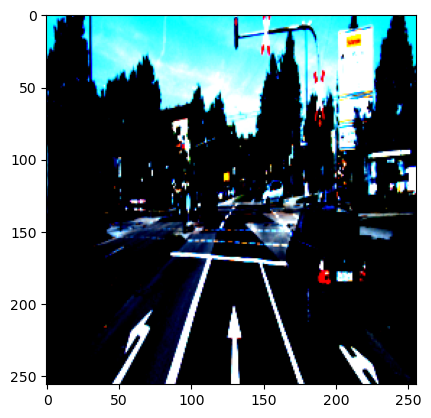

In [13]:
image.shape
image_show = image.permute(1, 2, 0).numpy()
plt.imshow(image_show)

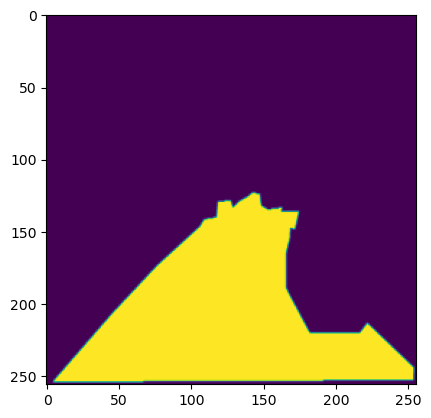

In [14]:
plt.imshow(mask.squeeze())

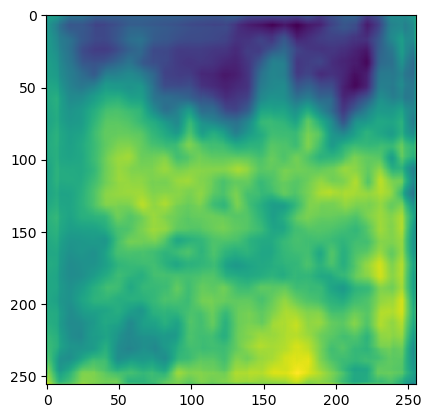

In [15]:
output = model(image.unsqueeze(0))
# output = torch.Re(output)
plt.imshow(output.squeeze().detach().numpy())

In [16]:
print(output.mean())
print(output.max())
print(output.min())

tensor(-2.2688, grad_fn=<MeanBackward0>)
tensor(7.4564, grad_fn=<MaxBackward1>)
tensor(-16.4056, grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


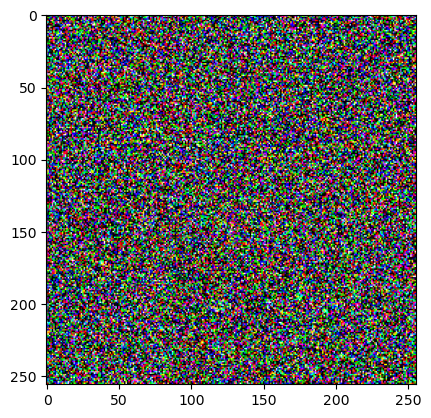

In [17]:
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

dummy_input = dummy_input[0].permute(1, 2, 0).numpy()
plt.imshow(dummy_input)

In [18]:
dummy_input[0]

array([[-1.48784959e+00,  9.34439719e-01,  1.97913826e+00],
       [-2.26520944e+00,  8.97991359e-01,  8.24832693e-02],
       [-4.24853593e-01, -2.15121508e+00,  6.89908981e-01],
       [ 2.10574412e+00, -8.80788982e-01,  9.98604670e-02],
       [-2.14473009e-01,  5.72594106e-01,  1.67686844e+00],
       [ 1.01400948e+00, -2.05321312e-01, -1.23855770e-01],
       [-4.25800979e-01, -1.95193201e-01,  4.73365873e-01],
       [ 4.32166934e-01, -1.58407509e-01, -1.74371529e+00],
       [-4.80963260e-01,  1.36289370e+00, -2.00960904e-01],
       [-2.20361397e-01, -5.51451385e-01, -8.06959197e-02],
       [ 1.18779278e+00, -1.15423489e+00,  4.21973526e-01],
       [-1.61499858e-01,  5.63959360e-01, -8.37190092e-01],
       [-5.09134471e-01, -7.12810338e-01, -6.34342134e-01],
       [ 4.06047761e-01, -5.93803406e-01, -2.13053524e-01],
       [ 8.94245565e-01,  5.49998522e-01,  9.09543693e-01],
       [-2.23370031e-01, -4.78029013e-01,  2.80732751e-01],
       [ 9.99864459e-01,  1.81100607e+00

In [19]:
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)
output = model(dummy_input)


In [20]:
dummy_input.shape

torch.Size([1, 3, 256, 256])

In [21]:
output.squeeze().shape

torch.Size([256, 256])

In [22]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [23]:
def calculate_iou(preds, labels, threshold=0.5, smooth=1e-6):
    """
    Calculate the Intersection over Union (IoU) between predicted and ground truth masks.
    
    Args:
        preds (torch.Tensor): Predicted masks of shape (batch_size, 1, height, width).
        labels (torch.Tensor): Ground truth masks of shape (batch_size, 1, height, width).
        threshold (float): Threshold to convert predicted probabilities to binary (default: 0.5).
        smooth (float): Smoothing factor to avoid division by zero (default: 1e-6).
    
    Returns:
        torch.Tensor: Mean IoU over the batch.
    """
    # Threshold the predictions to binary values
    preds = (preds > threshold).float()
    preds = preds.bool()
    labels = labels.bool()
    # Calculate intersection and union
    intersection = (preds & labels).float().sum((1, 2, 3))  # Sum over each batch item
    union = (preds | labels).float().sum((1, 2, 3))  # Sum over each batch item

    # Compute IoU for each batch element
    iou = (intersection + smooth) / (union + smooth)  # IoU for each batch item

    # Return mean IoU over the batch
    return iou.mean()


In [62]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyperparameters
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
PATIENCE = 10


# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define the loss function (Binary Cross-Entropy)
criterion = nn.BCEWithLogitsLoss()

iou_iter_list = []
loss_iter_list = []
iou_epoch_list = []
loss_epoch_list = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    print(f"Epoch {epoch+1}/{EPOCHS}")


    # Training loop
    for i, data in enumerate(train_loader):
        images, masks = data['image'].to(device), data['segmentation_mask'].to(device)
        
        # Forward pass
        outputs = model(images)
        # outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        
     # Calculate running loss and IoU
        running_loss += loss.item()
        running_iou += calculate_iou(outputs, masks).item()

        loss_iter_list.append(loss.item())
        iou_iter_list.append(calculate_iou(outputs, masks).item())

        print(f"Batch {i+1}/{len(train_loader)} - Loss: {loss.item():.4f}, IoU: {calculate_iou(outputs, masks).item():.4f}" ,  flush=True)


    # Calculate average loss and IoU for the epoch
    avg_train_loss = running_loss / len(train_loader)
    avg_train_iou = running_iou / len(train_loader)

    loss_epoch_list.append(avg_train_loss)
    iou_epoch_list.append(avg_train_iou)
    
    print(f"Epoch {epoch+1} - Average Train Loss: {avg_train_loss:.4f}, Average Train IoU: {avg_train_iou:.4f}\n", flush=True)


Epoch 1/200
Batch 1/51 - Loss: 0.2034, IoU: 0.4947
Batch 2/51 - Loss: 3.5177, IoU: 0.1841
Batch 3/51 - Loss: 1.5850, IoU: 0.3006
Batch 4/51 - Loss: 0.1768, IoU: 0.7527
Batch 5/51 - Loss: 0.4629, IoU: 0.0000
Batch 6/51 - Loss: 0.7653, IoU: 0.0019
Batch 7/51 - Loss: 0.2763, IoU: 0.1219
Batch 8/51 - Loss: 0.1537, IoU: 0.5732
Batch 9/51 - Loss: 0.1221, IoU: 0.8076
Batch 10/51 - Loss: 0.2216, IoU: 0.7147
Batch 11/51 - Loss: 0.1453, IoU: 0.6606
Batch 12/51 - Loss: 0.1786, IoU: 0.3618
Batch 13/51 - Loss: 0.3324, IoU: 0.3031
Batch 14/51 - Loss: 0.1702, IoU: 0.4066
Batch 15/51 - Loss: 0.1882, IoU: 0.3801
Batch 16/51 - Loss: 0.1728, IoU: 0.5369
Batch 17/51 - Loss: 0.2459, IoU: 0.6576
Batch 18/51 - Loss: 0.2162, IoU: 0.7136
Batch 19/51 - Loss: 0.1942, IoU: 0.7583
Batch 20/51 - Loss: 0.1639, IoU: 0.7476
Batch 21/51 - Loss: 0.1568, IoU: 0.6132
Batch 22/51 - Loss: 0.1646, IoU: 0.5099
Batch 23/51 - Loss: 0.1414, IoU: 0.4873
Batch 24/51 - Loss: 0.1323, IoU: 0.5573
Batch 25/51 - Loss: 0.1139, IoU: 0.65

KeyboardInterrupt: 

Batch 1
Images shape: torch.Size([4, 3, 256, 256])
Masks shape: torch.Size([4, 1, 256, 256])


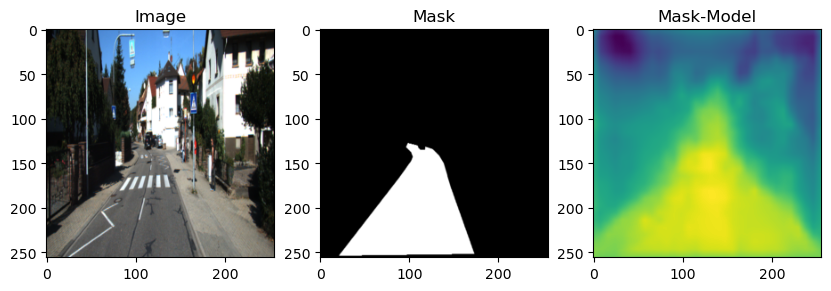

In [72]:
for i, data in enumerate(train_loader):
    images, masks = data['image'], data['segmentation_mask']
    image = images[0]
    inv_normalize = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    image = inv_normalize(image)
    image = image.permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8) 

    outputs = model(images)
    print(f"Batch {i+1}")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    # Display the first image and mask in the batch
    plt.figure(figsize=(10,5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.subplot(1, 3, 2)
    plt.imshow(masks[0].cpu().numpy().squeeze(), cmap='gray')
    plt.title('Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(outputs[0].permute(1, 2, 0).detach().numpy())
    plt.title('Mask-Model')
    plt.show()
    break 